# Feature Engineering and Modeling

In [1]:
# import libraries
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, HalvingRandomSearchCV

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import EarlyStopping

gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [2]:
# import datasets
cases_df = pd.read_csv('../clean_data/Cases_Normalized_per_100k.csv')
cases_df.head()

,county,totalcountconfirmed,totalcountdeaths,newcountconfirmed,newcountdeaths,date,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS,population,confirmedper100k,newlyconfirmedper100k,deathper100k,newdeath100k,7dayrollingavg_newlyconfirmed,7dayrollingavg_newdeath,7dayrollingavg_newlyconfirmed_rawnumber,7dayrollingavg_newdeath_rawnumber
0,Alameda,29.0,0.0,29,0,2020-03-18,0.019,0.008,0.055,0.123,0.795,1671329,1.735146,1.735146,0.000000,0.000000,NaN,NaN,NaN,NaN
1,Alameda,36.0,0.0,7,0,2020-03-19,0.019,0.008,0.055,0.123,0.795,1671329,2.153974,0.418828,0.000000,0.000000,NaN,NaN,NaN,NaN
2,Alameda,42.0,0.0,6,0,2020-03-20,0.019,0.008,0.055,0.123,0.795,1671329,2.512970,0.358996,0.000000,0.000000,NaN,NaN,NaN,NaN
3,Alameda,62.0,0.0,20,0,2020-03-21,0.019,0.008,0.055,0.123,0.795,1671329,3.709623,1.196652,0.000000,0.000000,NaN,NaN,NaN,NaN
4,Alameda,72.0,1.0,10,1,2020-03-22,0.019,0.008,0.055,0.123,0.795,1671329,4.307949,0.598326,0.059833,0.059833,NaN,NaN,NaN,NaN


In [3]:
cases_df.describe()

,totalcountconfirmed,totalcountdeaths,newcountconfirmed,newcountdeaths,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS,population,confirmedper100k,newlyconfirmedper100k,deathper100k,newdeath100k,7dayrollingavg_newlyconfirmed,7dayrollingavg_newdeath,7dayrollingavg_newlyconfirmed_rawnumber,7dayrollingavg_newdeath_rawnumber
count,17486.000000,17486.000000,17486.000000,17486.000000,17486.000000,17486.000000,17486.000000,17486.000000,17486.000000,1.748600e+04,17486.000000,17486.000000,17486.000000,17486.000000,17138.000000,1.713800e+04,17138.000000,17138.000000
mean,11864.667048,196.650292,161.083438,1.810248,0.032278,0.030698,0.063649,0.158543,0.714797,6.824013e+05,1376.034085,19.064878,18.045945,0.192028,18.765891,1.879600e-01,157.596352,1.758040
std,45130.684475,784.510735,777.737090,9.369938,0.028532,0.026178,0.033899,0.040410,0.092762,1.456244e+06,1844.120809,43.558129,26.737033,0.789122,30.428782,3.736882e-01,722.052706,7.694817
min,0.000000,0.000000,-578.000000,-16.000000,0.001000,0.000000,0.004000,0.058000,0.482000,1.129000e+03,0.000000,-73.260073,0.000000,-5.543545,-6.977150,-7.919349e-01,-1.142857,-1.428571
25%,83.000000,1.000000,1.000000,0.000000,0.015000,0.013000,0.040000,0.134000,0.661000,4.590500e+04,92.744186,0.472810,0.900810,0.000000,1.955926,1.205385e-15,1.857143,0.000000
50%,930.000000,13.000000,13.000000,0.000000,0.023000,0.023000,0.058000,0.156000,0.737000,1.928430e+05,628.750867,6.212531,7.342413,0.000000,7.778405,5.235521e-02,16.714286,0.142857
75%,7530.000000,105.000000,81.000000,0.000000,0.043000,0.043000,0.084000,0.186000,0.786000,7.621480e+05,2037.323376,19.737046,25.743593,0.000000,21.290293,2.194966e-01,84.142857,1.000000
max,937985.000000,12955.000000,28549.000000,318.000000,0.140000,0.135000,0.162000,0.276000,0.889000,1.003911e+07,15252.019756,1860.053144,250.531137,27.717723,566.793296,6.335479e+00,15711.142857,232.428571


In [4]:
# convert date to datetime
cases_df['date'] = pd.to_datetime(cases_df['date'])

In [5]:
# drop no longer needed columns
cases_df.drop(['totalcountconfirmed', 'totalcountdeaths', 'newcountconfirmed',
              'newcountdeaths', 'NEVER', 'RARELY', 'SOMETIMES', 'FREQUENTLY', 
              'ALWAYS', 'deathper100k', 'newdeath100k', 'confirmedper100k', 'population',
               'newlyconfirmedper100k' ,'7dayrollingavg_newlyconfirmed_rawnumber', '7dayrollingavg_newdeath_rawnumber'], 
             axis = 1, inplace = True)
cases_df.head()

,county,date,7dayrollingavg_newlyconfirmed,7dayrollingavg_newdeath
0,Alameda,2020-03-18,NaN,NaN
1,Alameda,2020-03-19,NaN,NaN
2,Alameda,2020-03-20,NaN,NaN
3,Alameda,2020-03-21,NaN,NaN
4,Alameda,2020-03-22,NaN,NaN


In [6]:
hospitals_df = pd.read_csv('../clean_data/hospitals_by_county.csv')
hospitals_df.head()

,county,todays_date,hospitalized_covid_confirmed_patients,hospitalized_suspected_covid_patients,hospitalized_covid_patients,all_hospital_beds,icu_covid_confirmed_patients,icu_suspected_covid_patients,icu_available_beds
0,Kings,2020-03-29,2.0,5.0,7.0,292.0,1.0,0.0,2.0
1,Yolo,2020-03-29,2.0,3.0,5.0,251.0,1.0,1.0,0.0
2,San Diego,2020-03-29,121.0,211.0,332.0,4459.0,77.0,39.0,205.0
3,Modoc,2020-03-29,0.0,0.0,0.0,11.0,0.0,0.0,0.0
4,Mono,2020-03-29,0.0,1.0,1.0,292.0,0.0,0.0,2.0


In [7]:
hospitals_df['todays_date'] = pd.to_datetime(hospitals_df['todays_date'])

In [8]:
hospitals_df.drop(['hospitalized_covid_confirmed_patients', 'hospitalized_suspected_covid_patients', 
                   'icu_covid_confirmed_patients', 'icu_suspected_covid_patients'],
                 axis = 1, inplace = True)
hospitals_df.head()

,county,todays_date,hospitalized_covid_patients,all_hospital_beds,icu_available_beds
0,Kings,2020-03-29,7.0,292.0,2.0
1,Yolo,2020-03-29,5.0,251.0,0.0
2,San Diego,2020-03-29,332.0,4459.0,205.0
3,Modoc,2020-03-29,0.0,11.0,0.0
4,Mono,2020-03-29,1.0,292.0,2.0


In [9]:
cases_hosp_df = cases_df.merge(hospitals_df, how = 'inner', left_on = ['county','date'], right_on = ['county', 'todays_date'])
cases_hosp_df.head()

,county,date,7dayrollingavg_newlyconfirmed,7dayrollingavg_newdeath,todays_date,hospitalized_covid_patients,all_hospital_beds,icu_available_beds
0,Alameda,2020-03-29,1.153915,0.042738,2020-03-29,127.0,2694.0,119.0
1,Alameda,2020-03-30,1.384698,0.051285,2020-03-30,148.0,3248.0,146.0
2,Alameda,2020-03-31,1.478721,0.042738,2020-03-31,150.0,1832.0,77.0
3,Alameda,2020-04-01,1.307770,0.042738,2020-04-01,128.0,2427.0,106.0
4,Alameda,2020-04-02,1.478721,0.051285,2020-04-02,133.0,2550.0,112.0


In [10]:
cases_hosp_df.drop('todays_date', axis = 1, inplace = True)

In [11]:
# do a group by so we can create predictions per county
county_df = cases_hosp_df.groupby(['county', 'date']).mean()

In [12]:
county_df.index.get_level_values('county').unique()[0]

'Alameda'

In [13]:
county_df.loc['Los Angeles']

,7dayrollingavg_newlyconfirmed,7dayrollingavg_newdeath,hospitalized_covid_patients,all_hospital_beds,icu_available_beds
date,,,,,
2020-03-29,2.468916,0.048382,1621.0,7333.0,345.0
2020-03-30,2.957007,0.056920,1878.0,9612.0,456.0
2020-03-31,3.369679,0.059766,1952.0,9386.0,445.0
2020-04-01,3.951689,0.079688,2071.0,10350.0,492.0
2020-04-02,4.219214,0.086803,2088.0,10268.0,488.0
...,...,...,...,...,...
2021-01-09,136.689733,1.995055,8190.0,19580.0,319.0
2021-01-10,139.811809,2.101781,8270.0,19462.0,340.0
2021-01-11,144.309933,2.187161,8279.0,19573.0,339.0


In [160]:
la_df = county_df.loc['Los Angeles'].tail(50)
features = ['hospitalized_covid_patients']
X = la_df[features]
y = la_df[['7dayrollingavg_newlyconfirmed']].values

In [161]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = False, test_size = 0.4)

In [162]:
mms = MinMaxScaler()
X_train_sc = mms.fit_transform(X_train)
X_test_sc = mms.transform(X_test)

In [163]:
# Create training sequences
train_sequences = TimeseriesGenerator(X_train_sc, y_train, length = 14,  batch_size = 128)

In [164]:
# Create test sequences
batch_x, batch_y = train_sequences[0]

In [165]:
test_sequences = TimeseriesGenerator(X_test_sc, y_test, length = 14,  batch_size = 128)

In [166]:
input_shape = train_sequences[0][0][0].shape

In [167]:
input_shape

(14, 1)

In [168]:
# Design RNN
model = Sequential()
model.add(LSTM(60, input_shape = (input_shape), return_sequences = True))
model.add(Dropout(0.2))
model.add(Dense(30, activation = 'swish', kernel_regularizer = l2(0.01)))
model.add(Dense(10, activation = 'swish', kernel_regularizer = l2(0.01)))
model.add(Dense(1))

In [169]:
model.compile(optimizer=Adam(lr = 0.005), loss = 'mae')

In [170]:
history = model.fit(train_sequences, validation_data = (test_sequences), epochs = 1000, verbose = 0)

In [171]:
X_test_sc[-14:].shape

(14, 1)

In [172]:
future_pred_count = 14
future = []
batch = X_test_sc[-future_pred_count:].reshape((1, future_pred_count, 1))
model.predict(batch)[0].shape

for i in range(future_pred_count):
    pred = model.predict(batch)[0]
    future.append(pred)
    batch = np.append(batch[:, 1:, :], [[pred[i]]] , axis = 1)

In [182]:
dates = [la_df.index[-1] + pd.tseries.offsets.DateOffset(days = x) for x in range(0,15)]
future_date = pd.DataFrame(index = dates[1:], columns = X.columns)
future_date.head()

,hospitalized_covid_patients
2021-01-14,NaN
2021-01-15,NaN
2021-01-16,NaN
2021-01-17,NaN
2021-01-18,NaN


In [183]:
future[0]

array([[111.50711],
       [125.98835],
       [128.15535],
       [128.46846],
       [128.48743],
       [128.48743],
       [128.48743],
       [128.48743],
       [128.48743],
       [128.48743],
       [128.48743],
       [128.48743],
       [128.48743],
       [128.48743]], dtype=float32)

In [184]:
df_predict = pd.DataFrame(future[0], index = future_date[-14:].index, columns = ['Prediction'])
df_predict.head()

,Prediction
2021-01-14,111.507111
2021-01-15,125.988350
2021-01-16,128.155350
2021-01-17,128.468460
2021-01-18,128.487427


In [185]:
df_test = pd.concat([la_df, df_predict], axis = 1)
df_test

,7dayrollingavg_newlyconfirmed,7dayrollingavg_newdeath,hospitalized_covid_patients,all_hospital_beds,icu_available_beds,Prediction
2020-11-25,41.614401,0.295985,2194.0,20201.0,611.0,NaN
2020-11-26,41.049468,0.308792,2252.0,20202.0,589.0,NaN
2020-11-27,41.531867,0.295985,2348.0,20087.0,612.0,NaN
2020-11-28,40.470304,0.323022,2513.0,20124.0,614.0,NaN
2020-11-29,43.858483,0.286024,2651.0,20078.0,603.0,NaN
...,...,...,...,...,...,...
2021-01-23,NaN,NaN,NaN,NaN,NaN,128.487427
2021-01-24,NaN,NaN,NaN,NaN,NaN,128.487427
2021-01-25,NaN,NaN,NaN,NaN,NaN,128.487427
2021-01-26,NaN,NaN,NaN,NaN,NaN,128.487427


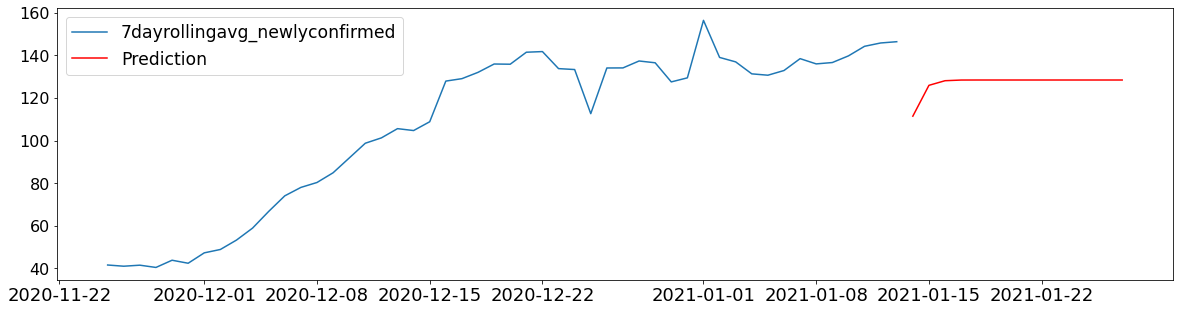

In [186]:
plt.figure(figsize=(20, 5))
plt.plot(df_test.index, df_test['7dayrollingavg_newlyconfirmed'])
plt.plot(df_test.index, df_test['Prediction'], color = 'r')
plt.legend(['7dayrollingavg_newlyconfirmed', 'Prediction'], loc = 'best', fontsize = 'xx-large')
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 16)
plt.show();

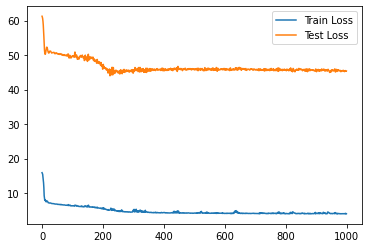

In [117]:
plt.plot(history.history['loss'], label = 'Train Loss')
plt.plot(history.history['val_loss'], label = 'Test Loss')
plt.legend();

In [ ]:
def county_model(df):
    features = [col for col in df.columns if not col == '7dayrollingavg_newlyconfirmed']
    X = df[features]
    y = df[['7dayrollingavg_newlyconfirmed']].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = False, test_size = 0.4)
    mms = MinMaxScaler() # use MinMaxScaler as we are dealing with purely positive values
    X_train_sc = mms.fit_transform(X_train)
    X_test_sc = mms.transform(X_test)
    
    # Create training sequences
    train_sequences = TimeseriesGenerator(X_train_sc, y_train, length = 14,  batch_size = 128)
    
    # Create test sequences
    batch_x, batch_y = train_sequences[0]
    test_sequences = TimeseriesGenerator(X_test_sc, y_test, length = 14,  batch_size = 128)
    input_shape = train_sequences[0][0][0].shape
    
    model = Sequential()
    model.add(LSTM(60, input_shape = (input_shape), return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(60, return_sequences = True))
    model.add(Dropout(0.2))
    model.add(Dense(30, activation = 'swish', kernel_regularizer = l2(0.001)))
    model.add(Dense(10, activation = 'swish', kernel_regularizer = l2(0.001)))
    model.add(Dense(1))
    model.compile(optimizer=Adam(lr = 0.005), loss = 'mae')
    early_stop = EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 1, mode = 'auto')
    history = model.fit(train_sequences, validation_data = (test_sequences), epochs = 1000, verbose = 0, callbacks = [early_stop])
    
    return model

In [ ]:
# generate models for all 58 counties
for i in county_df.index.get_level_values('county').unique:
    model_df = county_df.loc[i]
    model = county_model(model_df)
    model.save(f'./county_models/{i}')